In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm 
import pandas as pd

In [21]:
class CNNencoder(nn.Module):
    def __init__(self, emb, vocab_size, embedding_dim):
        super(CNNencoder, self).__init__()
        self.embeds = nn.Embedding(vocab_size,embedding_dim)
        self.embeds.weight = nn.Parameter(emb)
        self.conv1 = nn.Conv2d(1, 1, kernel_size=(3,embedding_dim))
        self.conv2 = nn.Conv2d(1, 1, kernel_size=(4,embedding_dim))
        self.conv3 = nn.Conv2d(1, 1, kernel_size=(5,embedding_dim))
        
        self.fc = nn.Linear(3,200)

    def forward(self, x):
        n = x.shape[1]
        num = x.shape[0]
        x = self.embeds(x).view(num,1,n,embedding_dim)
        x1 = F.max_pool1d(torch.transpose(F.relu(self.conv1(x).view(num,n-3+1,1)),dim0=1,dim1=2), n-3+1)
        x2 = F.max_pool1d(torch.transpose(F.relu(self.conv2(x).view(num,n-4+1,1)),dim0=1,dim1=2), n-4+1)
        x3 = F.max_pool1d(torch.transpose(F.relu(self.conv3(x).view(num,n-5+1,1)),dim0=1,dim1=2), n-5+1)
        x = torch.cat([x1,x2,x3],dim=1).squeeze()
        x = self.fc(x)
        return x

In [22]:
class etfscorer(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, attention_dim):
        super(etfscorer, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=False, dropout=.2)
        
#         self.wh = nn.Linear(hidden_dim, attention_dim,bias=False)
#         self.dw = nn.Dropout(p=.2)
#         self.act = nn.Tanh()
#         self.r = nn.Linear(attention_dim, 1,bias=False)     

        self.l1 = nn.Linear(hidden_dim, hidden_dim + int(hidden_dim/2))
        self.rel = nn.Tanh()
        self.dl1 = nn.Dropout(p=.2)
        self.l2 = nn.Linear(hidden_dim + int(hidden_dim/2),hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out,_ = self.lstm(x)
        mr = out[-1]
#         er = self.wh(out)
#         er = self.act(er)
#         er = self.dw(er)      
#         ar = self.r(er)
#         atr = F.softmax(ar,dim=0)
#         mr = (out*atr).sum(0)

        out = self.l1(mr)
        out = self.rel(out)
        out = self.dl1(out)
        out = self.l2(out)
        out = self.l3(out)
        
        return out

In [23]:
class finalmodel(nn.Module):
    def __init__(self, txtencoder,scorer):
        super(finalmodel, self).__init__()
        self.encoder = txtencoder
        self.scorer = scorer

    def forward(self, corp, price):
        N = corp.shape[0]
        encl = []
        for i in range(N):
            enc = self.encoder(corp[i])
            encl.append(enc)
        encl = torch.stack(encl)
        scinp = torch.cat([price.view(price.shape[0],price.shape[1],1),encl],dim=2)
        scinp = scinp.permute(1,0,2)
        out = self.scorer(scinp)
        out = torch.sigmoid(out)
        return out.flatten()

In [24]:
emb = torch.tensor(np.load('initembedding (1).npy')).float()
embedding_dim = emb.shape[1]
vocab_size = emb.shape[0]
encoder = CNNencoder(emb, vocab_size, embedding_dim)

In [25]:
sc_embedding_dim = 200
sc_hidden_dim = 300
sc_attention_dim = 200
scorer = etfscorer(sc_embedding_dim+1, sc_hidden_dim, sc_attention_dim)

In [26]:
model = finalmodel(encoder,scorer).cuda()

In [27]:
traincorpar = np.load('traincorpar.npy')
trainpricech = np.load('trainpricech.npy')
traintarget = (np.load('traintarget.npy') > 0) + 0

testcorpar = np.load('testcorpar.npy')
testpricech = np.load('testpricech.npy')
testtarget = (np.load('testtarget.npy') > 0) + 0

In [28]:
#train param
batch_size = 16
lr = .00001
num_epoch = 50
max_grad_norm = 0.5
wei_dec = .0001
log_interval = 600
# loss_fn = nn.MSELoss()
loss_fn = nn.BCELoss()
model_name = 'stockscoring_edit.pth'
optimizer = optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay =wei_dec)

In [29]:
class Dataset(Dataset):
    def __init__(self, corp, pricech, target):

        self.corp = torch.tensor(corp).long()
        self.pricech = torch.tensor(pricech).float()
        self.target = torch.tensor(target).float()

    def __getitem__(self, i):
        return (self.corp[i], self.pricech[:,i], self.target[i])

    def __len__(self):
        return (len(self.target))

In [30]:
traindataset = Dataset(traincorpar,trainpricech,traintarget)
testdataset = Dataset(testcorpar,testpricech,testtarget)

In [31]:
train_dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size)

In [32]:
trl = []
ttl = []
acc = []
preci = []

In [ ]:
#training scheme
for i in range(num_epoch):
    train_loss = 0
    test_loss = 0
    model.train()
    #### Training
    for batch_id, (x_c,x_p,y) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        out = model(x_c.cuda(),x_p.cuda())
    
        loss = loss_fn(out,y.cuda())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        lossavg = (loss/len(y)).data.cpu().numpy()
        train_loss += lossavg
        
        if batch_id % log_interval == 0:
            print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
        trl.append(train_loss / (batch_id+1))
        
        
    #### Evaluation on Testset
    model.eval()
    acc_cnt = 0
    cnt = 0
    prec_cnt = 0
    cnt2 = 0
    for batch_id, (x_c,x_p,y) in enumerate(tqdm(test_dataloader)):
        out = model(x_c.cuda(),x_p.cuda())

        loss = loss_fn(out,y.cuda())

        lossavg = (loss/len(y)).data.cpu().numpy()
        cnt += len(y)
        acc_cnt += sum((out > .5) == (y.cuda() > 0))
        cnt2 += sum(out > .5).detach().cpu()
        prec_cnt += sum(y[out > .5])
        test_loss += lossavg
    print('epoch: ',i+1,' Test Loss: ',test_loss / (batch_id+1), 'Acc: ',(acc_cnt/cnt).item(),'Prec: ', (prec_cnt/cnt2).item())
    if len(acc) > 0:
        if max(acc) < (acc_cnt/cnt).item():
            torch.save(model.state_dict(),model_name)
    else : torch.save(model.state_dict(),model_name)
    ttl.append((test_loss/ (batch_id+1)))
    acc.append((acc_cnt/cnt).item())
    preci.append((prec_cnt/cnt2).item())

  0%|          | 0/6100 [00:00<?, ?it/s]

Epoch:  1  Batch ID:  0  Train Loss:  0.04264872148633003
Epoch:  1  Batch ID:  600  Train Loss:  0.04334005348371983
Epoch:  1  Batch ID:  1200  Train Loss:  0.043334787371851424
Epoch:  1  Batch ID:  1800  Train Loss:  0.043289900957495554
Epoch:  1  Batch ID:  2400  Train Loss:  0.04329027386784851
Epoch:  1  Batch ID:  3000  Train Loss:  0.043285768244493726
Epoch:  1  Batch ID:  3600  Train Loss:  0.04324483110884169
Epoch:  1  Batch ID:  4200  Train Loss:  0.043256263079472425
Epoch:  1  Batch ID:  4800  Train Loss:  0.04326543294031455
Epoch:  1  Batch ID:  5400  Train Loss:  0.04327049206992671
Epoch:  1  Batch ID:  6000  Train Loss:  0.04327431040241944


  0%|          | 0/4180 [00:00<?, ?it/s]

epoch:  1  Test Loss:  0.043458580965416854 Acc:  0.48384973406791687 Prec:  nan


  0%|          | 0/6100 [00:00<?, ?it/s]

Epoch:  2  Batch ID:  0  Train Loss:  0.04482661560177803
Epoch:  2  Batch ID:  600  Train Loss:  0.04332601821387865
Epoch:  2  Batch ID:  1200  Train Loss:  0.043325887730873994
Epoch:  2  Batch ID:  1800  Train Loss:  0.04327571888488905
Epoch:  2  Batch ID:  2400  Train Loss:  0.04327142929060168
Epoch:  2  Batch ID:  3000  Train Loss:  0.04326057714502917


In [36]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
outs = []
ys = []
i=0
test_loss=0
model.eval()
acc_cnt = 0
cnt = 0
prec_cnt = 0
cnt2 = 0
for batch_id, (x_c,x_p,y) in enumerate(tqdm(test_dataloader)):
    out = model(x_c.cuda(),x_p.cuda())

    loss = loss_fn(out,y.cuda())

    lossavg = (loss/len(y)).data.cpu().numpy()
    cnt += len(y)
    cnt2 += sum(out > .5).detach().cpu()
    prec_cnt += sum(y[out > .5])
    acc_cnt += sum((out > .5) == y.cuda())
    test_loss += lossavg
    outs += out.tolist()
    ys += y.tolist()
print('epoch: ',i+1,' Test Loss: ',test_loss / (batch_id+1), 'Acc: ',(acc_cnt/cnt).item(),'Prec: ', (prec_cnt/cnt2).item())

  0%|          | 0/4180 [00:00<?, ?it/s]

In [ ]:
outs = []
ys = []
i=0
test_loss=0
model.eval()
acc_cnt = 0
cnt = 0
prec_cnt = 0
cnt2 = 0
for batch_id, (x_c,x_p,y) in enumerate(tqdm(train_dataloader)):
    out = model(x_c.cuda(),x_p.cuda())

    loss = loss_fn(out,y.cuda())

    lossavg = (loss/len(y)).data.cpu().numpy()
    cnt += len(y)
    cnt2 += sum(out > .5).detach().cpu()
    prec_cnt += sum(y[out > .5])
    acc_cnt += sum((out > .5) == y.cuda())
    test_loss += lossavg
    outs += out.tolist()
    ys += y.tolist()
print('epoch: ',i+1,' Test Loss: ',test_loss / (batch_id+1), 'Acc: ',(acc_cnt/cnt).item(),'Prec: ', (prec_cnt/cnt2).item())

  0%|          | 0/6100 [00:00<?, ?it/s]

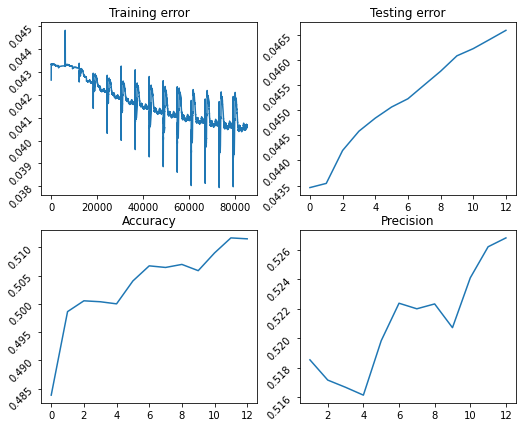

In [98]:
plt.figure(figsize=(8.5,7))
plt.subplot(2,2,1)
plt.plot(trl)
plt.title('Training error')
plt.yticks(rotation=45)

plt.subplot(2,2,2)
plt.plot(ttl)
plt.title('Testing error')
plt.yticks(rotation=45)

plt.subplot(2,2,3)
plt.plot(acc)
plt.title('Accuracy')
plt.yticks(rotation=45)

plt.subplot(2,2,4)
plt.plot(preci)
plt.title('Precision')
plt.yticks(rotation=45)

plt.show()

* Training error는 하락하고 Testing error는 상승함으로 Overfitting되어 가고 있음
* 하지만 Accuracy와 Precision이 지속적으로 상승하는 것을 확인 할 수 있음

In [85]:
print('Model summary')
print('Precision on 1:',np.mean(np.array(ys)[np.array(outs) > .5]))
print('Recall on 1:',sum(np.array(ys)[np.array(outs) > .5])/sum(np.array(ys)==1))
print('Precision on 0:',1-np.mean(np.array(ys)[np.array(outs) <= .5]))
print('Recall on 0:',sum(np.array(ys)[np.array(outs) <= .5]==0)/sum(np.array(ys)==0))

Model summary
Precision on 1: 0.5261973099217738
Recall on 1: 0.5417777262718739
Precision on 0: 0.4952447820259144
Recall on 0: 0.47960192854493755


In [44]:
nums = []
predicted = []
for i in np.arange(.2,1,.01):
    num = sum(np.array(outs) > i)
    nums.append(num)
    predicted.append(np.mean(np.array(ys)[np.array(outs) > i]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Precision')

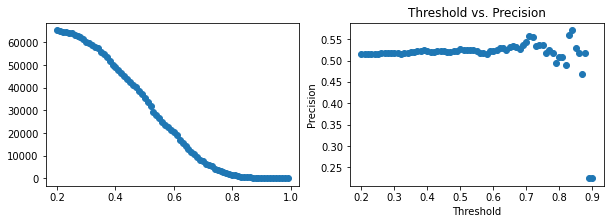

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(np.arange(.2,1,.01),nums)
plt.subplot(1,2,2)
plt.scatter(np.arange(.2,1,.01),predicted)
plt.title('Threshold vs. Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')

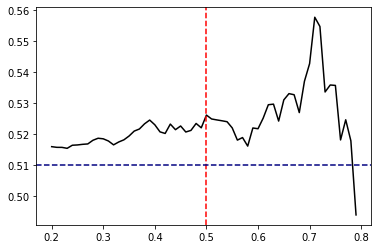

In [96]:
#Test threshold
plt.plot(np.arange(.2,1,.01)[:-20],predicted[:-20],color='black') 
plt.axvline(.5,linestyle='--',color='red')
plt.axhline(.51,linestyle='--',color='navy')
#strong linear pattern after .5, found that this was great point to consider investing
#but precision significantly drops for very high score

* Threshold를 증가하여 예측할때 마다 예측 Precision이 증가하는것을 볼 수 있음
* 특히, .5 이후 강한 upward linear pattern을 확인 할 수 있음
* .5 이상의 점수를 받은 경우, 투자를 고려하는 전략을 선택할 수 있을 만하며, 큰 점수일 경우 큰 confidence로 볼 수도 있음
* .7 이상 점수를 받는 경우에 precision이 급락하는걸 볼 수 있는데, 이건 .7 이상 점수를 받은 경우가 드물어서일 가능성이 클 것으로 보임

In [56]:
testans = pd.read_csv('testans.csv').iloc[:,1:]

In [67]:
testans['label'] = pd.Series(ys)
testans['pred'] = pd.Series(outs)

In [73]:
subtestans = testans[['date','name','pred']]

In [76]:
scores_format = subtestans.set_index(['date','name'])['pred'].unstack()

In [77]:
scores_format.to_csv('scores_format.csv')